## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 3.0 MB/s eta 0:00:00


In [3]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## **Loading the dataset**

In [4]:
# # run the following code load dataset in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# # read the CSV file
stock_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/0822-NLP/week4/moduleproj/stock_news.csv")

In [8]:
# # Create a copy of the dataset
stock = stock_news.copy()

## **Data Overview**

### Displaying the first few rows of the dataset

In [9]:
# # show the first 5 rows of the data
stock.head(5)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [10]:
stock.tail()

,Date,News,Open,High,Low,Close,Volume,Label
344,2019-04-30,"Media mogul Oprah Winfrey, known for influenc...",50.764999,50.849998,49.7775,48.70879,186139600,-1
345,2019-04-30,"European shares fell on Tuesday, with banks u...",50.764999,50.849998,49.7775,48.70879,186139600,-1
346,2019-04-30,This article reports that the S&P 500 reached...,50.764999,50.849998,49.7775,48.70879,186139600,-1
347,2019-04-30,The Federal Reserve is anticipated to keep in...,50.764999,50.849998,49.7775,48.70879,186139600,-1
348,2019-04-30,"In the first quarter, South Korea's Samsung E...",50.764999,50.849998,49.7775,48.70879,186139600,0


### Understanding the shape of the dataset

In [11]:
# check the shape of the data
stock.shape

(349, 8)

Data has 349 rows and 8 columns

### Checking the data types of the columns

In [12]:
# # data types
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB



*   Date and News columns are of type Object
*   Everyother column is int or float
*   Date need to converted to Datetime type

In [13]:
##  convert the 'Date' column in the 'stock' DataFrame to datetime format
stock['Date'] = pd.to_datetime(stock['Date'])

### Checking the statistical summary

In [14]:
# #  statistical summary
stock.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Date,349,NaN,NaN,NaN,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00,NaN
News,349,349,The tech sector experienced a significant dec...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,349.0,NaN,NaN,NaN,46.229233,37.567501,41.740002,45.974998,50.7075,66.817497,6.442817
High,349.0,NaN,NaN,NaN,46.700458,37.817501,42.244999,46.025002,50.849998,67.0625,6.507321
Low,349.0,NaN,NaN,NaN,45.745394,37.305,41.482498,45.639999,49.7775,65.862503,6.391976
Close,349.0,NaN,NaN,NaN,44.926317,36.254131,40.246914,44.596924,49.11079,64.805229,6.398338
Volume,349.0,NaN,NaN,NaN,128948236.103152,45448000.0,103272000.0,115627200.0,151125200.0,244439200.0,43170314.918964
Label,349.0,NaN,NaN,NaN,-0.054441,-1.0,-1.0,0.0,0.0,1.0,0.715119



*   Data is for dates between 2019-01092 to 2019-04-30
*   There is huge difference in min and max volumes


### Checking the duplicate values

In [15]:
# # let's check for duplicate values in the data
stock.duplicated().sum()

0

There are no  duplcate data entries

### Checking for missing values

In [16]:
# # check for missing values in the data
stock.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


## **Exploratory Data Analysis**

### Univariate Analysis

#### Observations on Label

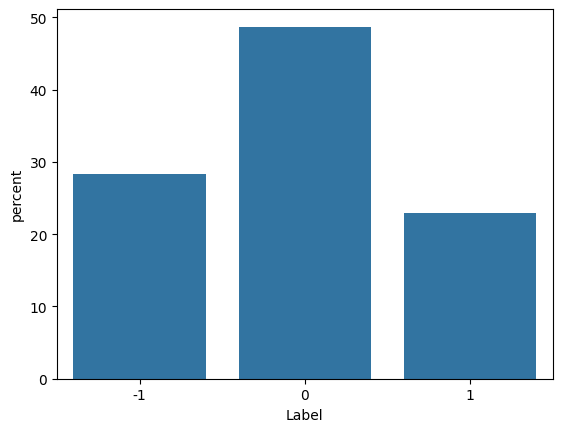

In [17]:
sns.countplot(data=stock, x="Label", stat="percent");


*   50% of labels are neutral
*   around 20% have postive sentiment and 30% have negative sentiment



#### Density Plot of Price (Open,High,Low,Close)

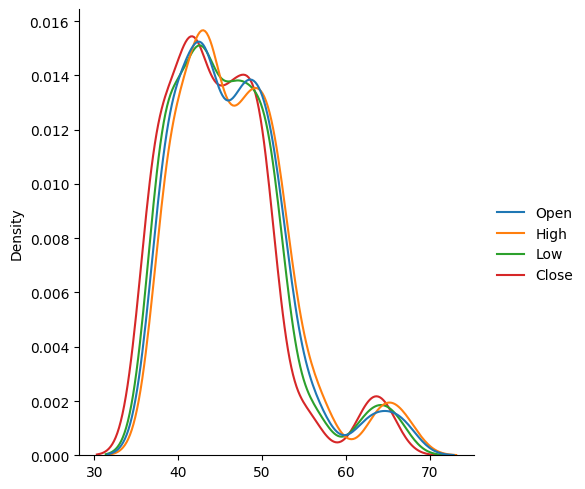

In [18]:
# # code to plot a density plot of ["Open","High","Low","Close"] all in a single plot
sns.displot(data=stock[["Open","High","Low","Close"]], kind="kde", palette="tab10");

#### Observations on Volume

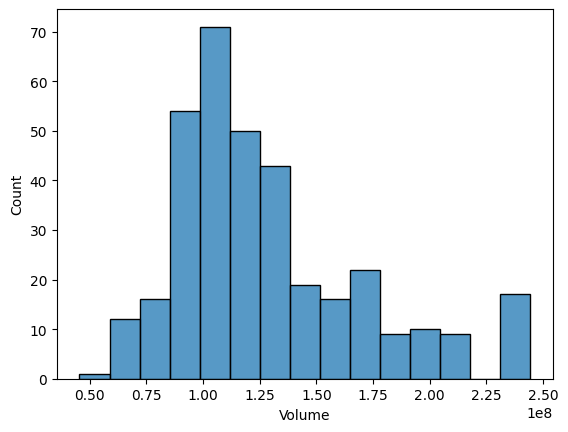

In [19]:
# # plot a histogram of Volume
sns.histplot(stock, x='Volume');


1.   mean volume is 128m
2.   50% percentile is aroun 115m
3.   There few outliers in the data with very high volumes


#### Observations on News length

In [20]:
#Calculating the total number of words present in the news content.
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' ')))


stock['news_len'].describe()

,news_len
count,349.000000
mean,49.312321
std,5.727770
min,19.000000
25%,46.000000
50%,50.000000
75%,53.000000
max,61.000000



*   Average numnber of words in a news is 49
*   Maximum number of words is 61
*   Ignoring few news below 40 words, rest of the Word count looks evenly distributed



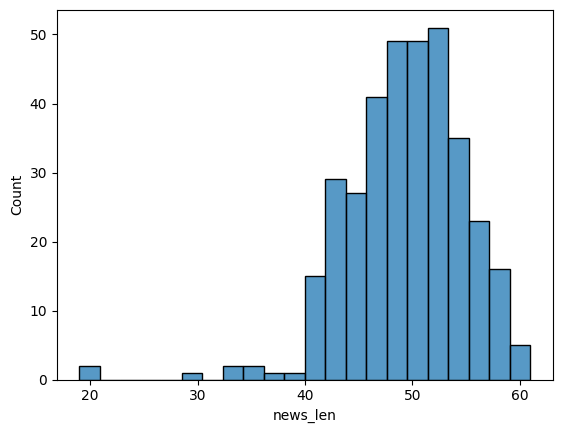

In [21]:
sns.histplot(data=stock,x="news_len"); # histogram of news_len column

### Bivariate Analysis

#### Correlation

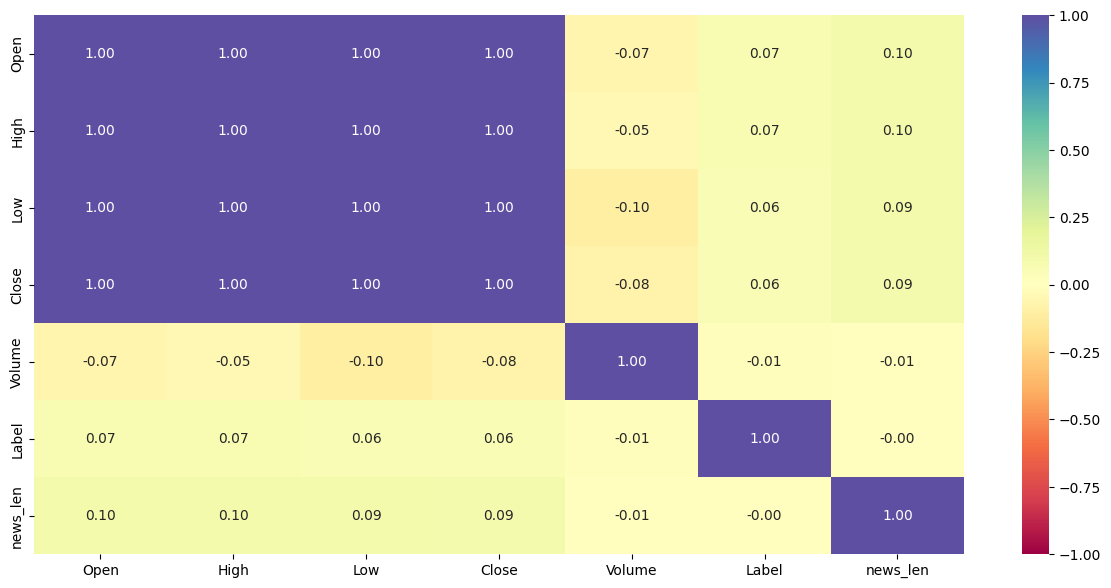

In [22]:
# Find out correaltion
numeric_df = stock.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

# plot the heatmap

plt.figure(figsize=(15, 7))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()



*   High,Low,Open and Close are highly correlated

#### Label vs Price (Open, High, Low, Close)

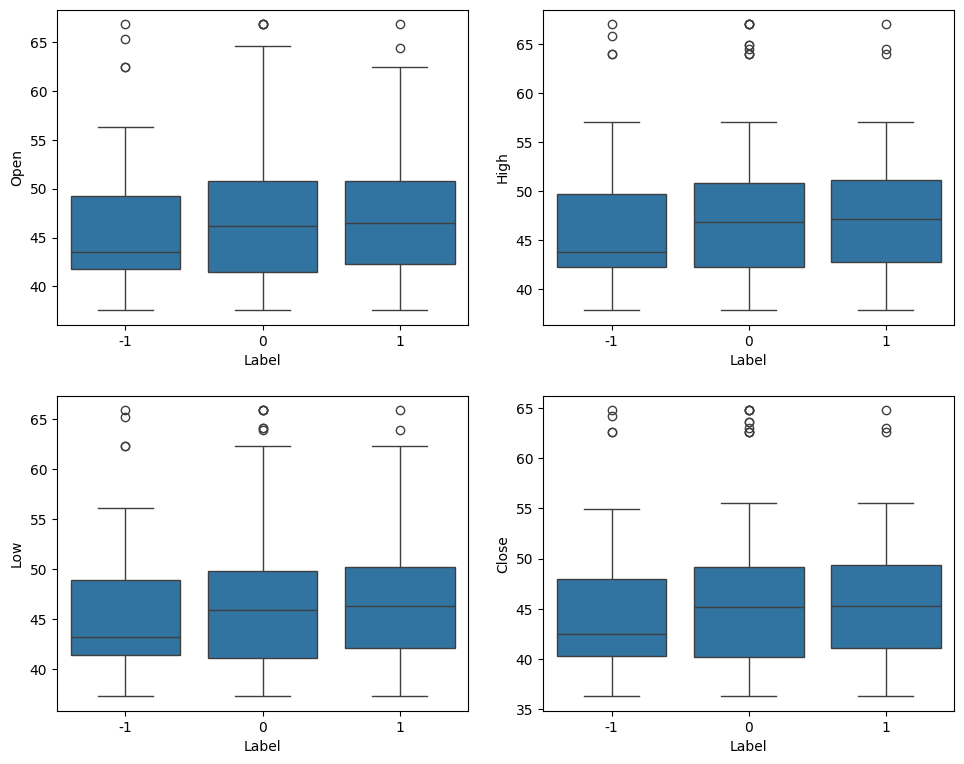

In [23]:

plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()


*   Open ,High , Low and Close stock prices have their median price going down for negative sentiment
*   Neurtal and Positive sentiment have similar effect on median price of stock



#### Label vs Volume

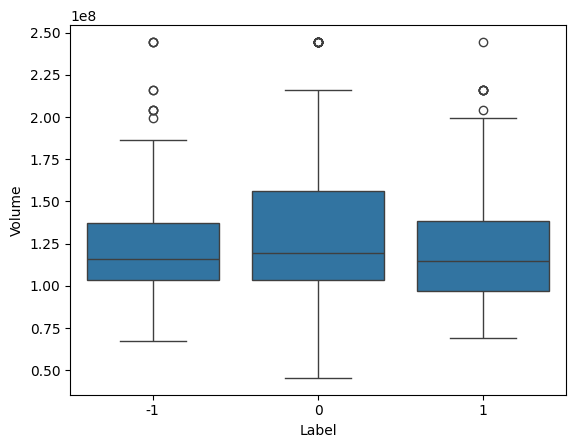

In [24]:
# boxplot of Label vs Volume
sns.boxplot(
    data=stock, x="Label", y="Volume"
);

*   Median volume are similar between all sentiments
*   There outliers when sentiments are negative or postive, this indicates heavy volume driven sale or buy activity based on market sentiment



#### Date vs Price (Open, High, Low, Close)

In [25]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


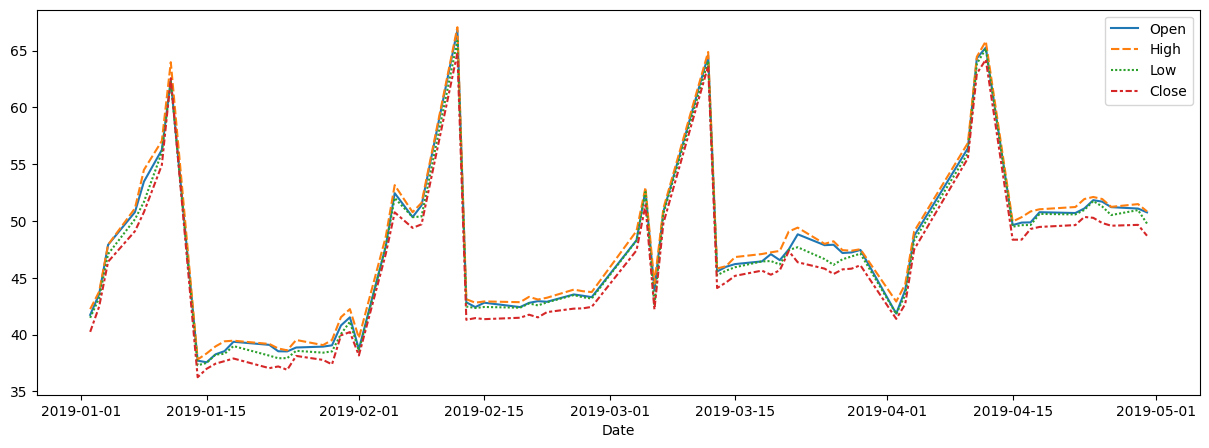

In [26]:
# lineplot of all the variables except Volume
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop("Volume", axis=1));


*   Open,High,Low and Close prices show a pattern of price going up till middle of the month and then sudden drop of price during middle of the month





#### Volume vs Close Price

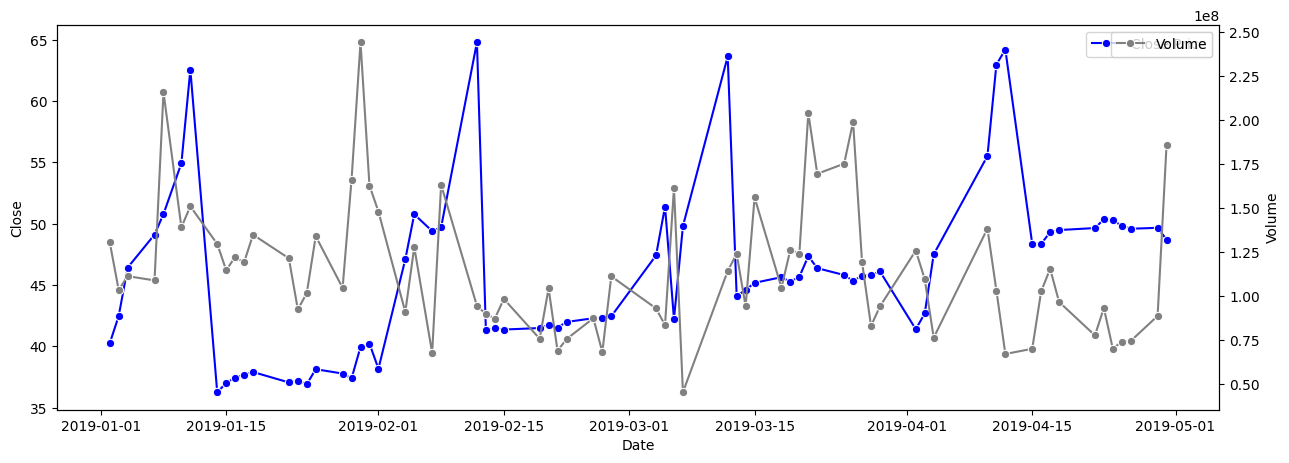

In [27]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

Volume and Close price have inverse relationship. Volume goes up when close price goes down and vice versa

## **Data Preprocessing**

In [28]:
# statistical summary of the 'Date' column
stock["Date"].describe()

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


Data is for dates between 2019=01-02 through 2019-04-30

### Train-test-validation Split

In [29]:
# We will use 'Date' is before '2019-04-01' as trainig data set
X_train = stock[(stock['Date'] < '2019-04-01')].reset_index()

# 'Date' between '2019-04-01 to '2019-04-16' is used for validation data set
X_val = stock[(stock['Date'] >= '2019-04-01') & (stock['Date'] < '2019-04-16')].reset_index()

# 'Date' is above '2019-04-16' will be used as test data set
X_test = stock[stock['Date'] >= '2019-04-16'].reset_index()

In [30]:
# # pick the 'Label' column as the target variable
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

In [31]:
# # print the shape of X_train,X_val,X_test,y_train,y_val and y_test
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 10)
Validation data shape (21, 10)
Test data shape  (42, 10)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


## **Word Embeddings**

### Word2Vec

In [32]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock['News'].values]

In [33]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [34]:
# Print the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


Let's check out a few word embeddings obtained using the model.

In [35]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([ 0.00333006,  0.04395907,  0.00532164,  0.02381548, -0.00318612,
       -0.0505824 ,  0.03533392,  0.08405934,  0.00962431, -0.01525708,
        0.01152611, -0.02236084,  0.00143442,  0.0118421 , -0.02908157,
       -0.02558967,  0.02090883, -0.01271315, -0.00218399, -0.01327385,
       -0.02682298,  0.00284079,  0.03685502,  0.00761172,  0.01468728,
        0.00603853, -0.04411415,  0.00618475, -0.0181859 , -0.03534115,
        0.01420925, -0.02153471,  0.00339444, -0.00298409, -0.00461905,
        0.01695897,  0.01710605, -0.03834861,  0.00191793, -0.01065909,
       -0.01618467, -0.00162044, -0.00183645, -0.02636678,  0.01591075,
        0.04008467,  0.00021263,  0.01050007, -0.00181375,  0.02724795,
        0.0202561 ,  0.00528196, -0.01640828,  0.01307363, -0.01078766,
        0.02744919,  0.01348794,  0.0037658 ,  0.01584064, -0.00479315,
       -0.00670154, -0.01613693, -0.00018406,  0.01080119,  0.00644203,
        0.01453463,  0.00176877,  0.01479667, -0.02271528, -0.00

In [36]:
# Checking the word embedding of a random word
word = "economy"
model_W2V.wv[word]

array([ 2.43762461e-03,  6.36477070e-03, -1.87390469e-05,  3.51128331e-03,
       -2.46176403e-03, -8.54833983e-03,  8.53663590e-03,  1.55217927e-02,
        4.18082986e-04, -1.36782997e-03,  2.42182263e-03, -4.53739567e-03,
        7.64247787e-04,  1.97557546e-03, -4.79157921e-03, -3.33037274e-03,
        2.24175211e-03, -3.35465558e-03, -6.09298295e-04, -3.83541617e-03,
       -1.19083375e-03,  1.67389761e-03,  5.10936324e-03,  2.31566769e-03,
        4.56474163e-03,  1.59849320e-03, -4.49990155e-03, -1.36788737e-03,
       -2.44923239e-03, -5.66299213e-03,  2.99891853e-03, -2.04016105e-03,
        3.14503652e-03, -1.72660919e-03,  2.05704651e-04,  3.55586503e-03,
        1.45545765e-03, -2.93733459e-03,  5.67059382e-04, -1.80813100e-03,
       -4.71135322e-03,  5.16084896e-04,  1.34359335e-03, -5.16848220e-03,
       -1.06706982e-03,  6.76340144e-03, -1.65522634e-03,  5.00852754e-03,
       -2.82771816e-03,  5.85474027e-03,  6.69613131e-04, -1.19459779e-04,
       -2.25988543e-03,  

In [37]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [38]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [39]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.5961201190948486


In [40]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


### GloVe

In [42]:
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/Colab Notebooks/0822-NLP/week4/moduleproj/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [43]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


Let's check out a few word embeddings.

In [44]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [45]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [46]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [47]:
vec_size=100

In [48]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [49]:
# creating a dataframe of the vectorized documents
start = time.time()

## Apply GloVe on 'News' column on Training data
X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

## Apply GloVe on 'News' column on validation data
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

## Apply GloVe on 'News' column on Test data
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  32.15334129333496


In [50]:
#print the shapes of the final dataframes
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


### Sentence Transformer

#### Defining the model

In [51]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Encoding the dataset

In [52]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
# encoding the dataset
start = time.time()

## Apply Sentence Transformer on 'News' column on Training ,Validation and Test data
X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  2.6375041007995605


In [54]:
#Print the shapes of the final dataframes
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


- Each news content has been converted to a 384-dimensional vector.

## **Sentiment Analysis**

### Model Evaluation Criterion
Based on Exploratory Data Analysis, it was noticed both negative and positive sentiments drive stock volume activity (sell or buy) . So its imprtant to quantify which sentiment is more important from revenue stand point.To simplify our model criteria, we are assuming negative sentiment has profound impact and possible monitory loss if financial result wouldn't proactively sell the stock. we will use Recall as metric to evaluate model performance. Reacall which will show models performance to minimize false positives.


-


### Utility Functions

In [55]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [56]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [57]:
# Building the model using Random Forest Classifier


base_wv = RandomForestClassifier(random_state=42)


# Fitting on train data
base_wv.fit(X_train_wv, y_train)

RandomForestClassifier(random_state=42)

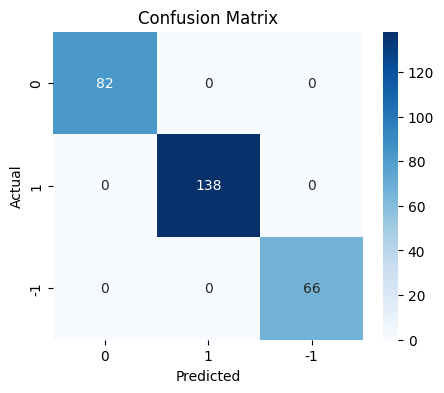

In [58]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

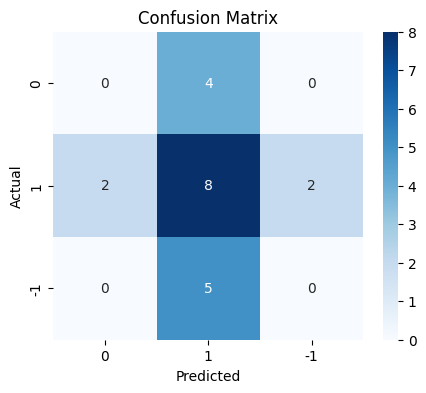

In [59]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [60]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [61]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.268908  0.315271


### Base Model - GloVe

In [62]:
#Building the model using RandomForestClassifier


base_wv = RandomForestClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_gl, y_train)

RandomForestClassifier(random_state=42)

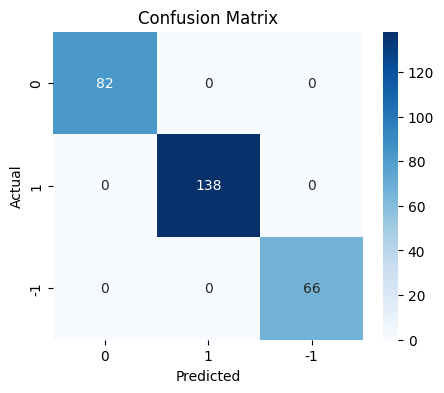

In [63]:
## plot the confusion matrix for the train data
plot_confusion_matrix(base_wv,X_train_gl,y_train)

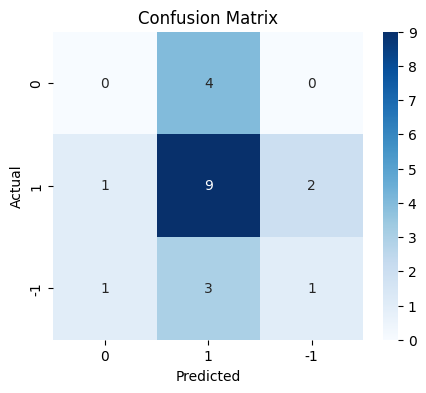

In [64]:
## plot the confusion matrix for the validation data
plot_confusion_matrix(base_wv,X_val_gl,y_val)

In [65]:
#Calculating different metrics on training data
base_train_gl=model_performance_classification_sklearn(base_wv,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [66]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_wv,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.400794  0.426871


### Base Model - Sentence Transformer

In [67]:
# Building the model using RandomForestClassifier

base_wv = RandomForestClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_st, y_train)

RandomForestClassifier(random_state=42)

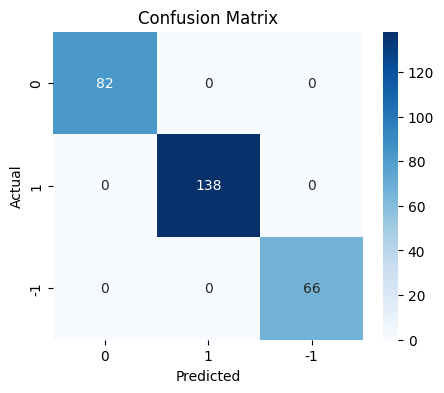

In [68]:
## plot the confusion matrix for the train data
plot_confusion_matrix(base_wv,X_train_st,y_train)

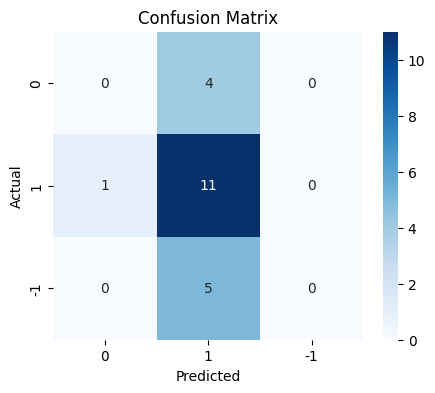

In [69]:
# plot the confusion matrix for the validation data
plot_confusion_matrix(base_wv,X_val_st,y_val)

In [70]:
#Calculating different metrics on training data
base_train_st=model_performance_classification_sklearn(base_wv,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [71]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_wv,X_val_st,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.314286  0.392857


### Tuned Model - Word2Vec

**Note**: The parameter grid provided below is a sample grid. It can be modified depending on the compute power of the system being used.

In [72]:
start = time.time()

tuned_wv = RandomForestClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  147.57497453689575


In [73]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=5, max_features=0.4, min_samples_split=9,
                       random_state=42)

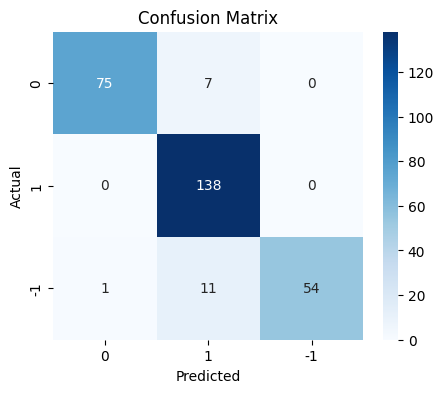

In [74]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

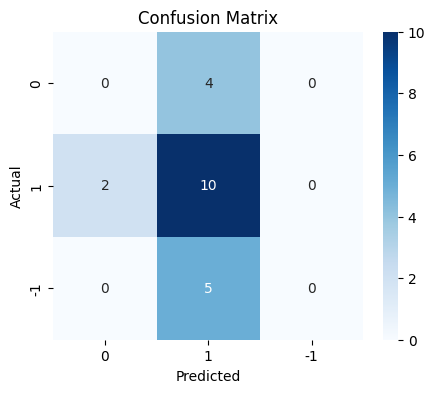

In [75]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [76]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.933566  0.933566   0.940552  0.932864


In [77]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.300752  0.368664


### Tuned Model - GloVe

In [78]:
start = time.time()


tuned_wv = RandomForestClassifier(random_state=42)


parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  84.45785975456238


In [79]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=7,
                       random_state=42)

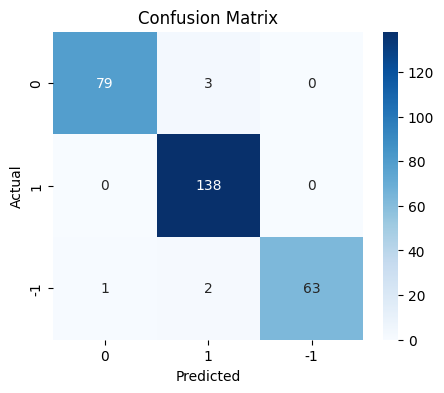

In [81]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

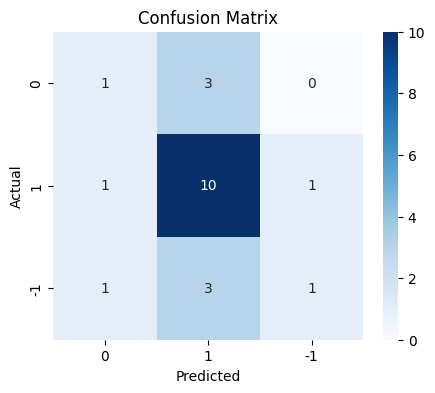

In [82]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [83]:
#Calculating different metrics on training data
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.979021  0.979021   0.979545  0.978968


In [84]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.539683  0.530612


### Tuned Model - Sentence Transformer

In [85]:
start = time.time()


tuned_wv = RandomForestClassifier(random_state=42)


parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  161.44313216209412


In [86]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=5, max_features=0.4, min_samples_split=9,
                       random_state=42)

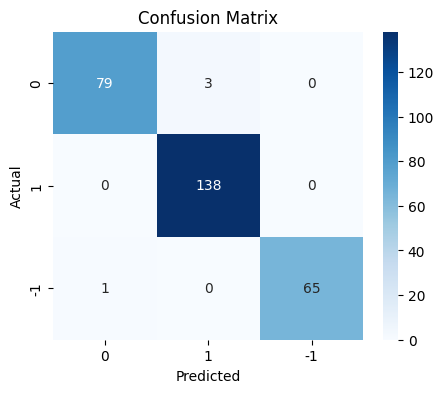

In [87]:
## plot the confusion matrix for the training data
plot_confusion_matrix(tuned_st,X_train_st,y_train)

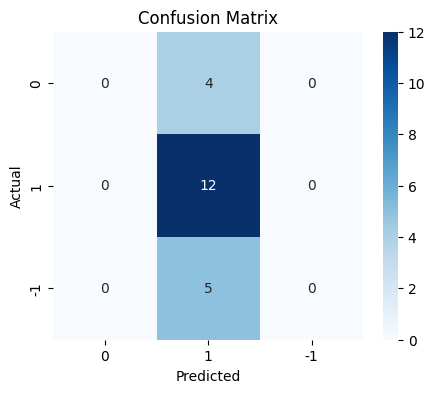

In [88]:
## plot the confusion matrix for the validation data
plot_confusion_matrix(tuned_st,X_val_st,y_val)


In [89]:
#Calculating different metrics on training data
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.986014  0.986014    0.98615  0.985971


In [90]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.326531  0.415584


### Model Performance Summary and Final Model Selection

In [91]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,0.933566,0.979021,0.986014
Recall,1.0,1.0,1.0,0.933566,0.979021,0.986014
Precision,1.0,1.0,1.0,0.940552,0.979545,0.986150
F1,1.0,1.0,1.0,0.932864,0.978968,0.985971


In [92]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.380952,0.476190,0.523810,0.476190,0.571429,0.571429
Recall,0.380952,0.476190,0.523810,0.476190,0.571429,0.571429
Precision,0.268908,0.400794,0.314286,0.300752,0.539683,0.326531
F1,0.315271,0.426871,0.392857,0.368664,0.530612,0.415584



*   Tuned Models have better performance on Validation data
*   All base model are overfitting on training data
*   Glove and Sentence Transformer tuned model have similar Accuracy and Recall cores, But Glove outperformed Setence transformer in Precision and F1 scores
*   Recommendation is to use Glove model



### Model Performance Check on Test Data

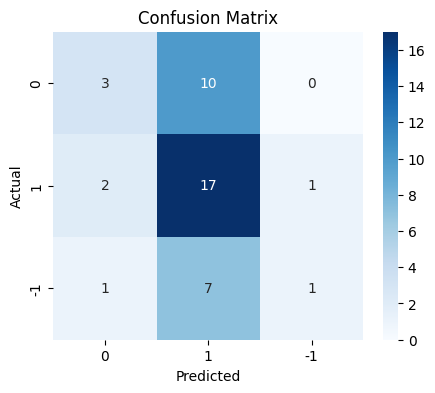

In [93]:
plot_confusion_matrix(tuned_gl,X_test_gl,y_test)

In [95]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(tuned_gl,X_test_gl,y_test)
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy  Recall  Precision        F1
0       0.5     0.5        0.5  0.436529


Glove model gave accuracy and recall of 50% on test data

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [1]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 161.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 86.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.1.1 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.1 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.1 which is incompatible.
pa

In [2]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [3]:
# # run the following code to load dataset in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
stock_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/0822-NLP/week4/moduleproj/stock_news.csv")

In [5]:
data = stock_news.copy()

#### Loading the model

In [6]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"


model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [7]:
#Use below snippet of code if the runtime is connected to GPU.
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=4500, #Context window
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [ ]:
# uncomment and run the following code in case GPU is not being used

# llm = Llama(
#     model_path=model_path,
#     n_ctx=4500, # Context window
#     n_cores=-2 # Number of CPU cores to use
# )

#### Aggregating the data weekly

In [8]:
# Convert the 'Date' column to datetime format.
data["Date"] = pd.to_datetime(data['Date'])

In [9]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [10]:
# Aggregate the grouped data on a weekly basis:
# concatenate 'content' values into a single string separated by ' || '.
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [105]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [11]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

##### Utility Functions

In [12]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [17]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=1024,
      temperature=0,
      top_p=0.95,
      top_k=50,
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

In [13]:
news = data_1.loc[0, 'News']

In [14]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [37]:
# Define the prompt for this task
prompt = """
    You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and identify the  Positive Events,Negative Events and keywords contained within it.

Instructions:
1. Read the news headline.
2. Identify the top three positive and negative keywords that are most likely to impact the price of the stock.

Return the output in JSON format  containing two keys, key1='Positive Events' with values as positive keywords and key2='Negative Events'  and values as negative keywords.
Do not include any other text in the output except the JSON.
"""

In [38]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

Llama.generate: prefix-match hit


 {
         "Positive Events": [],
         "Negative Events": ["Apple's Q1 revenue warning", "weak economic data from China and Europe", "partial U.S. government shutdown", "US-China trade tensions"]
       }

       The negative events identified in the news article are significant factors that led to a decline in Apple's stock price and negatively impacted related suppliers, causing broader market declines for tech indices such as Nasdaq 10. These events include Apple's revenue warning, weak economic data from China and Europe, partial U.S. government shutdown, and US-China trade tensions. There are no clear positive events identified in the news article that would positively impact the price of Apple's stock or related suppliers.
CPU times: user 15.8 s, sys: 5.16 s, total: 20.9 s
Wall time: 21.2 s


##### Checking the model output on the weekly data

In [39]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

100%|██████████| 18/18 [03:23<00:00, 11.28s/it]

CPU times: user 2min 53s, sys: 25.3 s, total: 3min 18s
Wall time: 3min 23s


In [40]:
# Print the first 5 rows of the 'Key_Events' column
data_1['Key Events'].head()

,Key Events
0,"{\n ""Positive Events"": [],\n ..."
1,"{\n ""Positive Events"": [""Sprint and ..."
2,"{\n ""Positive Events"": [""Apple CEO Tim..."
3,"{\n ""Positive Events"": [""IBM's stock..."
4,"{\n ""Positive Events"": [""Apple repor..."


##### Formatting the model output

In [41]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"{\n ""Positive Events"": [],\n ...","{'Positive Events': [], 'Negative Events': ['A..."
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{\n ""Positive Events"": [""Sprint and ...",{'Positive Events': ['Sprint and Samsung plan ...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""Positive Events"": [""Apple CEO Tim...",{'Positive Events': ['Apple CEO Tim Cook annou...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""Positive Events"": [""IBM's stock...",{'Positive Events': ['IBM's stock price increa...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""Positive Events"": [""Apple repor...",{'Positive Events': ['Apple reported higher-th...


In [42]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,Positive Events,Negative Events
0,[],"[Apple's Q1 revenue warning, weak economic dat..."
1,[Sprint and Samsung plan to release 5G smartph...,"[Geely forecasts flat sales for 2019, China's ..."
2,[Apple CEO Tim Cook announces internal staffin...,[U.S. stock market declined on Monday as conce...
3,"[IBM's stock price increased, Huawei expanding...",[Swiss National Bank governor emphasized negat...
4,[Apple reported higher-than-expected revenue a...,[Caterpillar Inc reported lower-than-expected ...


In [43]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,[],"[Apple's Q1 revenue warning, weak economic dat..."
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[Sprint and Samsung plan to release 5G smartph...,"[Geely forecasts flat sales for 2019, China's ..."
2,2019-01-20,The U.S. stock market declined on Monday as c...,[Apple CEO Tim Cook announces internal staffin...,[U.S. stock market declined on Monday as conce...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","[IBM's stock price increased, Huawei expanding...",[Swiss National Bank governor emphasized negat...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[Apple reported higher-than-expected revenue a...,[Caterpillar Inc reported lower-than-expected ...


## **Conclusions and Recommendations**

**Data Observations:**

*   Data is for dates between 2019-01092 to 2019-04-30
*   Around 20% have postive sentiment,30% have negative sentiment and 50% of labels are neutral
*   Open ,High , Low and Close stock prices have their median price going down for negative sentiment
*   Neurtal and Positive sentiment have similar effect on median price of stock
*   Volume and Close price have inverse relationship. Volume goes up when close price goes down and vice versa. This could be good investment opportunity


-**Llama LLM Model**
*   Llama model is able to identify positive and negatives evennts efficiently
*   Further feeding more news headlines will result in more accurate results from Llama

-**Tuned Glove Model**
*   Glove and Sentence Transformer tuned model have similar Accuracy and Recall cores.
*   Glove outperformed Setence transformer in Precision and F1 scores
Recommendation is to use Glove model

**Final Recommendations**:
*   Llama LLM looks promising with limited data, model is able to sythensize the information to identity postive and negative sentiments. Further model training on more data will result in more accurate results
*   Tuned Glove can also be used to train further, with limited Glove model is able to acheive  50% accuracy and recall scores which is impressive.
*   Analyst can use these models to predict stock price and improve investment strategies.
